In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from publik import modifier
from publik import plot
from pilnu_utils import * 

# Reinterpreting $B \to \pi \tau \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of two kinematic variables: $q^2$ and $\cos\theta_l$.

We use $q^2$ also as a fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [2]:
fitbins = np.linspace( 3.40, 26.41, 8).tolist()
q2bins = np.linspace(  3.40, 26.41, 6).tolist()
ctbins = np.linspace( -1.00,  1.00, 5).tolist()
binning = [q2bins, ctbins]

## Generate some SM samples

In [3]:
SMsamples = 50000

p = eos.Parameters()
o = eos.Options({'form-factors': 'BSZ2015', 'l': 'tau', 'model':'WET'})
k = eos.Kinematics({
    'q2':            5.0,  'q2_min':            3.4,     'q2_max':           26.41,
    'cos(theta_l)':  0.0,  'cos(theta_l)_min': -1.0,      'cos(theta_l)_max': +1.0,
})

pdf = eos.SignalPDF.make('B->pilnu::d^2Gamma/dq2/dcos(theta_l)', p, k, o)
obs = eos.Observable.make('B->pilnu::BR', p, k, o)
SMBR = obs.evaluate()

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

/home/lorenz/publik-group/venv_publik_group/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


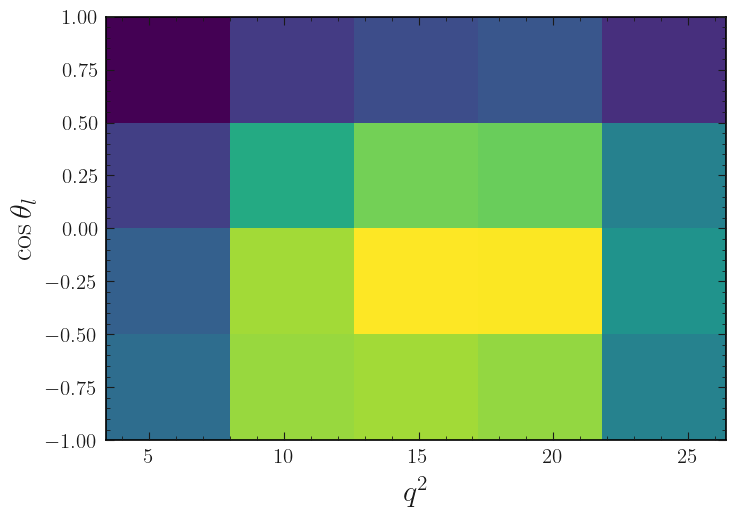

In [4]:
plt.hist2d(null_samples[:,0], null_samples[:,1], binning)
plt.xlabel(r'$q^2$')
plt.ylabel(r'$\cos\theta_l$')
plt.show()

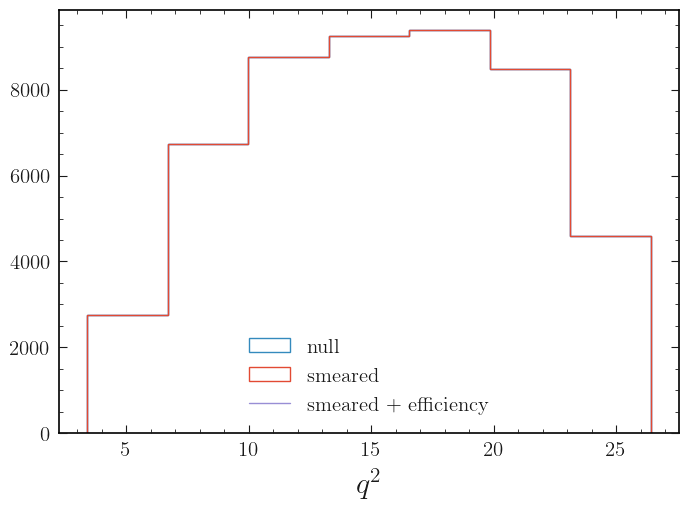

In [5]:
plt.hist(null_samples[:,0], fitbins, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples[:,0], fitbins, histtype='step', label='smeared')
# null_yields *= efficiency(bin_cents)
plt.stairs(null_yields, fitbins, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [6]:
p['ubtaunutau::Re{cVL}'     ].set(1.0)
p['ubtaunutau::Re{cSL}'     ].set(1.0)
p['ubtaunutau::Re{cT}'      ].set(0.0)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

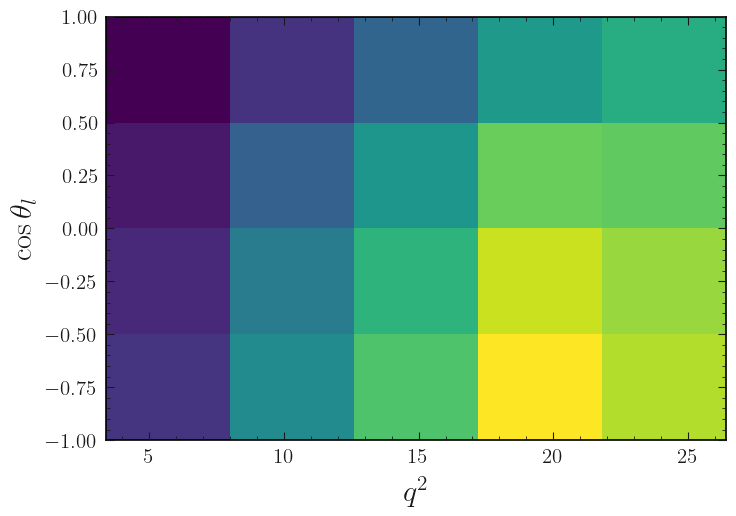

In [7]:
plt.hist2d(alt_samples[:,0], alt_samples[:,1], binning)
plt.xlabel(r'$q^2$')
plt.ylabel(r'$\cos\theta_l$')
plt.show()

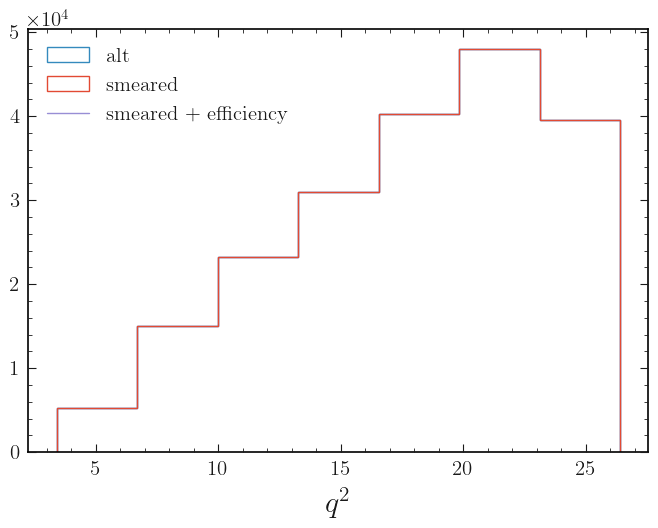

In [8]:
plt.hist(alt_samples[:,0], fitbins, histtype='step', label='alt')
alt_yields, _, _ = plt.hist(alt_samples[:,0], fitbins, histtype='step', label='smeared')
# null_yields *= efficiency(bin_cents)
plt.stairs(alt_yields, fitbins, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Set up the mapping distribution

In [9]:
mapping_dist = np.histogramdd([null_samples[:,0], null_samples[:,0], null_samples[:,1]], bins=[fitbins, q2bins, ctbins])[0]

## Set up the custom modifier

In [10]:
null = null_pred()
alt = alt_pred()

In [11]:
ana = analysis()
cvl = ana.parameters['ubtaunutau::Re{cVL}'     ].evaluate()
csl = ana.parameters['ubtaunutau::Re{cSL}'     ].evaluate()
ct  = ana.parameters['ubtaunutau::Re{cT}'      ].evaluate()
fp0 = ana.parameters['B->D::alpha^f+_0@BSZ2015'].evaluate()
fp2 = ana.parameters['B->D::alpha^f+_2@BSZ2015'].evaluate()
fp1 = ana.parameters['B->D::alpha^f+_1@BSZ2015'].evaluate()
f01 = ana.parameters['B->D::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->D::alpha^f0_2@BSZ2015'].evaluate()

In [12]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

,0,1,2,3,4
0,0.000149,0.001617,0.000967,0.002715,0.011957
1,0.001617,0.033203,0.146104,0.038435,0.204480
2,0.000967,0.146104,1.712060,0.075982,0.845943
3,0.002715,0.038435,0.075982,0.060394,0.305107
4,0.011957,0.204480,0.845943,0.305107,2.129121


In [13]:
new_params = {
                'cvl'   :{'inits': (1.0,), 'bounds': ((-2., 2.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.0,), 'bounds': ((-2., 2.),), 'paramset_type': 'unconstrained'},
                'ct '   :{'inits': (0.0,), 'bounds': ((-2., 2.),), 'paramset_type': 'unconstrained'},
                'FF'    :{'inits': (fp0, fp1, fp2, f01, f02), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2bins, ctbins])
cmod.expanded_pyhf

{'custom': (publik.custom_modifier.add.<locals>._builder,
  publik.custom_modifier.add.<locals>._applier),
 'histosys': (pyhf.modifiers.histosys.histosys_builder,
  pyhf.modifiers.histosys.histosys_combined),
 'lumi': (pyhf.modifiers.lumi.lumi_builder, pyhf.modifiers.lumi.lumi_combined),
 'normfactor': (pyhf.modifiers.normfactor.normfactor_builder,
  pyhf.modifiers.normfactor.normfactor_combined),
 'normsys': (pyhf.modifiers.normsys.normsys_builder,
  pyhf.modifiers.normsys.normsys_combined),
 'shapefactor': (pyhf.modifiers.shapefactor.shapefactor_builder,
  pyhf.modifiers.shapefactor.shapefactor_combined),
 'shapesys': (pyhf.modifiers.shapesys.shapesys_builder,
  pyhf.modifiers.shapesys.shapesys_combined),
 'staterror': (pyhf.modifiers.staterror.staterror_builder,
  pyhf.modifiers.staterror.staterror_combined)}

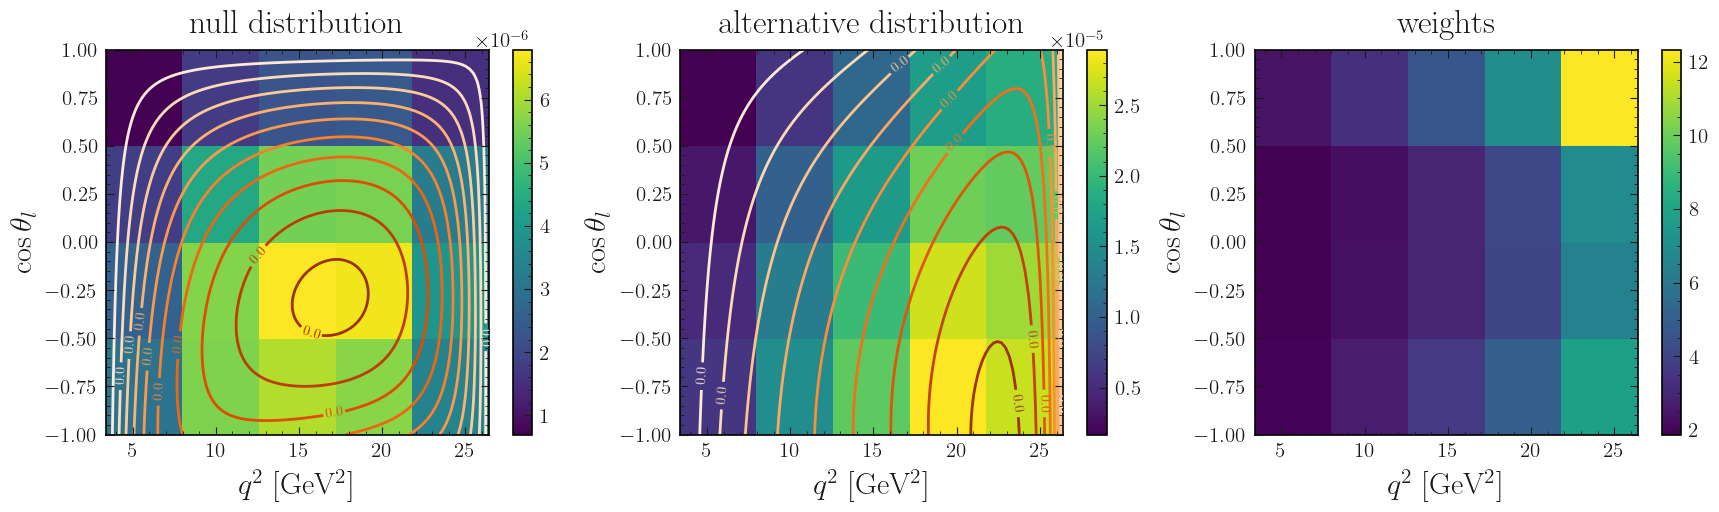

In [20]:
cvl = 1.0
csl = 1.0
ct  = 0.0

pars = (cvl, csl, ct, fp0, fp1, fp2, f01, f02)
labels = [r'$q^2$ [GeV$^2$]', r'$\cos\theta_l$']
plot.dists(cmod, pars, labels=labels, plot_weights=True, plot_dists=True);

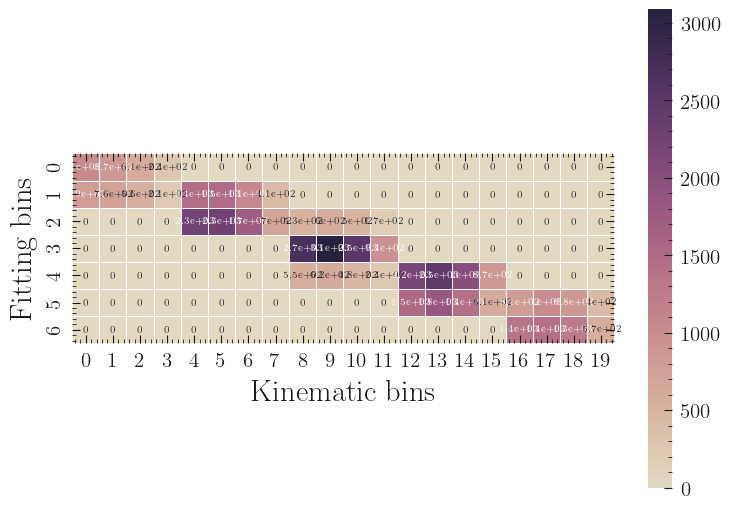

In [15]:
plot.map(cmod)

## Set up the model

In [16]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "weight_function",
                        "ibin": [i for i in range(len(fitbins)-1)],
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [2757.0, 6749.0, 8766.0, 9258.0, 9397.0, 8482.0, 4591.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [52.507142371300304,
        82.15229759416349,
        93.6269192059634,
        96.21850133939938,
        96.93812459502195,
        92.09777413162601,
        67.75691846593969]},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'weight_function',
        'ibin': [0, 1, 2, 3, 4, 5, 6]}}]}]}]}

## Save and load model

In [17]:
modifier.save('pilnu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('pilnu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [18]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]

# pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
# best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 0.00398659


{'cvl': array([0.99874654, 0.07367039]),
 'csl': array([1.0294383 , 0.02020926]),
 'ct ': array([-0.08763285,  0.10803504]),
 'FF_decorrelated[0]': array([3.19647520e-12, 9.93346666e-01]),
 'FF_decorrelated[1]': array([3.19647520e-12, 9.93346666e-01]),
 'FF_decorrelated[2]': array([3.19647520e-12, 9.93346666e-01]),
 'FF_decorrelated[3]': array([3.19647520e-12, 9.93346666e-01]),
 'FF_decorrelated[4]': array([3.19647520e-12, 9.93346666e-01]),
 'mu': array([1., 0.]),
 'stat': [[1.0177526635012129, 0.01488877790157317],
  [0.9907743728568101, 0.008976759144535329],
  [1.0077223765622008, 0.007551076878695717],
  [1.0133503202384884, 0.006982980554868012],
  [0.967728267512203, 0.006326164385693278],
  [0.9660134592014998, 0.007395825393816335],
  [1.0787457899789816, 0.009579341761231763]]}

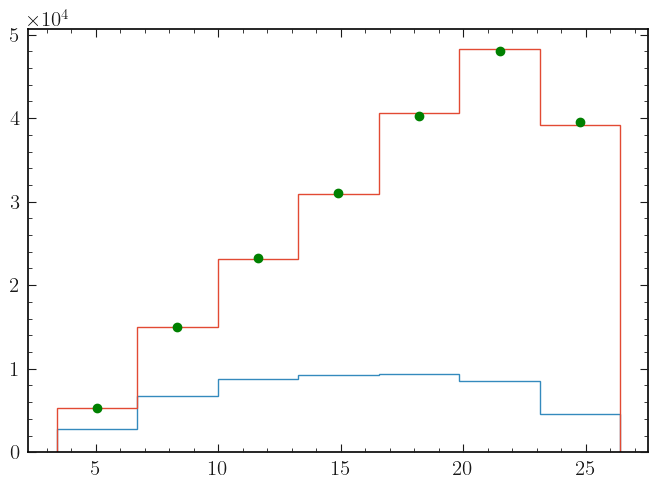

In [19]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), fitbins)
plt.stairs(model.expected_actualdata(best_fit[:,0]), fitbins)
bin_cents = (np.array(fitbins)[:-1] + np.array(fitbins)[1:])/2
plt.plot(bin_cents, alt_yields, 'og')